---

## Universidad de Costa Rica
### Escuela de Ingeniería Eléctrica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas

Segundo semestre del 2020

---

* Estudiante: **José Alberto Morera Guzmán**
* Carné: **B85431**
* Grupo: **1**

---
# `P4` - *Modulación digital IQ*

---
## 4. - Asignaciones del proyecto

### 4.1. - Modulación QPSK

* (50%) Realice una simulación del sistema de comunicaciones como en la sección 3.2., pero utilizando una modulación QPSK en lugar de una modulación BPSK. Deben mostrarse las imágenes enviadas y recuperadas y las formas de onda.

In [27]:
from PIL import Image
import numpy as np

def fuente_info(imagen):
    '''Una función que simula una fuente de
    información al importar una imagen y 
    retornar un vector de NumPy con las 
    dimensiones de la imagen, incluidos los
    canales RGB: alto x largo x 3 canales

    :param imagen: Una imagen en formato JPG
    :return: un vector de pixeles
    '''
    img = Image.open(imagen)
    
    return np.array(img)

In [28]:
import numpy as np

def rgb_a_bit(imagen):
    '''Convierte los pixeles de base 
    decimal (de 0 a 255) a binaria 
    (de 00000000 a 11111111).

    :param imagen: array de una imagen 
    :return: Un vector de (1 x k) bits 'int'
    '''
    # Obtener las dimensiones de la imagen
    x, y, z = imagen.shape
    
    # Número total de pixeles
    n_pixeles = x * y * z

    # Convertir la imagen a un vector unidimensional de n_pixeles
    pixeles = np.reshape(imagen, n_pixeles)

    # Convertir los canales a base 2
    bits = [format(pixel,'08b') for pixel in pixeles]
    bits_Rx = np.array(list(''.join(bits)))
    
    return bits_Rx.astype(int)

In [29]:
import numpy as np

def bits_a_rgb(bits_Rx, dimensiones):
    '''Un blque que decodifica el los bits
    recuperados en el proceso de demodulación

    :param: Un vector de bits 1 x k 
    :param dimensiones: Tupla con dimensiones de la img.
    :return: Un array con los pixeles reconstruidos
    '''
    # Cantidad de bits
    N = len(bits_Rx)

    # Se reconstruyen los canales RGB
    bits = np.split(bits_Rx, N / 8)

    # Se decofican los canales:
    canales = [int(''.join(map(str, canal)), 2) for canal in bits]
    pixeles = np.reshape(canales, dimensiones)

    return pixeles.astype(np.uint8)

In [30]:
import numpy as np

def modulador(bits, fc, mpp):
    
    bits_matriz = bits.reshape(len(bits)//2, 2)
    
    N = len(bits_matriz) # Cantidad de bits

    
    Tc = 1 / fc  
    t_periodo = np.linspace(0, Tc, mpp)
    
    portadora_I = np.cos(2*np.pi*fc*t_periodo)
    
    portadora_Q = np.sin(2*np.pi*fc*t_periodo) 

    # 3. Inicializar la señal modulada s(t)
    t_simulacion = np.linspace(0, N*Tc, N*mpp) 
    senal_Tx = np.zeros(t_simulacion.shape)
    senal_Tx_I = np.zeros(t_simulacion.shape)
    senal_Tx_Q = np.zeros(t_simulacion.shape)
    
    moduladora = np.zeros(t_simulacion.shape)  # señal de información
 
    # 4. Asignar las formas de onda según los bits (QPSK)
    
    bits_matriz = bits.reshape(len(bits)//2, 2)
    
    
    
    for i, bit in enumerate(bits_matriz):
        
        if bits_matriz[i,0] == 1:
            senal_Tx_I[i*mpp : (i+1)*mpp] = portadora_I
            
        else:
            senal_Tx_I[i*mpp : (i+1)*mpp] = portadora_I * -1
            
        if bits_matriz[i,1] == 1:
            senal_Tx_Q[i*mpp : (i+1)*mpp] = portadora_Q
            
        else:
            senal_Tx_Q[i*mpp : (i+1)*mpp] = portadora_Q * -1
        
        
   
    # 5. Calcular la potencia promedio de la señal modulada
    
    
    senal_Tx = senal_Tx_Q + senal_Tx_I
    
    Pm = (1 / (N*Tc)) * np.trapz(pow(senal_Tx, 2), t_simulacion)
    # Suma de portadoras
    
    return senal_Tx, Pm, portadora_I, portadora_Q, moduladora  

In [31]:
import numpy as np

def canal_ruidoso(senal_Tx, Pm, SNR):
    
    # Potencia del ruido generado por el canal
    Pn = Pm / pow(10, SNR/10)

    # Generando ruido auditivo blanco gaussiano
    ruido = np.random.normal(0, np.sqrt(Pn), senal_Tx.shape)

    # Señal distorsionada por el canal ruidoso
    senal_Rx = senal_Tx + ruido

    return senal_Rx

In [32]:
def demodulador(senal_Rx, portadora_I, portadora_Q, mpp):
 
    # Cantidad de muestras en senal_Rx
    M = len(senal_Rx)

    # Cantidad de bits en transmisión
    N = int(M / mpp)

    # Vector para bits obtenidos por la demodulación
    bits_Rx_I = np.zeros(N)
    bits_Rx_Q = np.zeros(N)
    bits_Rx = np.zeros(2*N)

    # Vector para la señal demodulada
    senal_demodulada = np.zeros(M)

    # Energía de un período de la portadora
    Es = np.sum(portadora_I*portadora_Q)

    # Demodulación
    for i in range(N):
        # Producto interno de dos funciones
        producto_I = senal_Rx[i*mpp : (i+1)*mpp] * portadora_I
        
        producto_Q = senal_Rx[i*mpp : (i+1)*mpp] * portadora_Q
        
        
        senal_demodulada[i*mpp : (i+1)*mpp] = producto_I + producto_Q
        
        Ep_I = np.sum(producto_I) 
        
        Ep_Q = np.sum(producto_Q)
        

        # Criterio de decisión por detección de energía
        
        if Ep_I > 0:
            bits_Rx_I[i] = 1
        else:
            bits_Rx_I[i] = 0
            
        if Ep_Q > 0:
            bits_Rx_Q[i] = 1
        else:
            bits_Rx_Q[i] = 0
            
            
    for j, bits_I in enumerate(bits_Rx_I):
        bits_Rx[2*j] = bits_I 
        
    for k, bits_Q in enumerate(bits_Rx_Q):
        bits_Rx[2*k+1] = bits_Q

    return bits_Rx.astype(int), senal_demodulada


Duración de la simulación:  12.053092956542969
556 errores, para un BER de 0.0008.


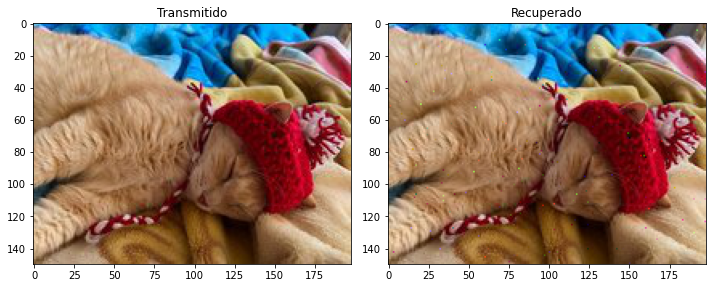

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Parámetros
fc = 5000  # frecuencia de la portadora
mpp = 20   # muestras por periodo de la portadora
SNR = 0    # relación señal-a-ruido del canal

# Iniciar medición del tiempo de simulación
inicio = time.time()

# 1. Importar y convertir la imagen a trasmitir
imagen_Tx = fuente_info('Crispy.jpg')
dimensiones = imagen_Tx.shape

# 2. Codificar los pixeles de la imagen
bits_Tx = rgb_a_bit(imagen_Tx)

# 3. Modular la cadena de bits usando el esquema BPSK
senal_Tx, Pm, portadora_I, portadora_Q, moduladora = modulador(bits_Tx, fc, mpp)

# 4. Se transmite la señal modulada, por un canal ruidoso
senal_Rx = canal_ruidoso(senal_Tx, Pm, SNR)

# 5. Se desmodula la señal recibida del canal
bits_Rx, senal_demodulada = demodulador(senal_Rx, portadora_I, portadora_Q, mpp)

# 6. Se visualiza la imagen recibida 
imagen_Rx = bits_a_rgb(bits_Rx, dimensiones)
Fig = plt.figure(figsize=(10,6))

# Cálculo del tiempo de simulación
print('Duración de la simulación: ', time.time() - inicio)

# 7. Calcular número de errores
errores = sum(abs(bits_Tx - bits_Rx))
BER = errores/len(bits_Tx)
print('{} errores, para un BER de {:0.4f}.'.format(errores, BER))

# Mostrar imagen transmitida
ax = Fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(imagen_Tx)
ax.set_title('Transmitido')

# Mostrar imagen recuperada
ax = Fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(imagen_Rx)
ax.set_title('Recuperado')
Fig.tight_layout()

plt.imshow(imagen_Rx)

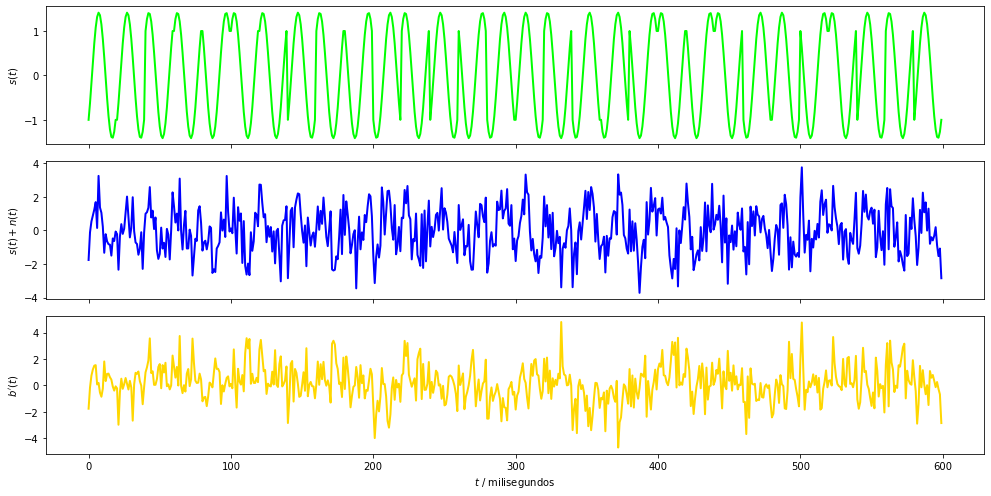

In [40]:
fig, (ax2, ax3, ax4) = plt.subplots(nrows=3, sharex=True, figsize=(14, 7))

# La onda cuadrada moduladora (bits de entrada)
#ax1.plot(moduladora[0:600], color='r', lw=2) 
#ax1.set_ylabel('$b(t)$')

# La señal modulada por BPSK
ax2.plot(senal_Tx[0:600], color='lime', lw=2) 
ax2.set_ylabel('$s(t)$')

# La señal modulada al dejar el canal
ax3.plot(senal_Rx[0:600], color='b', lw=2) 
ax3.set_ylabel('$s(t) + n(t)$')

# La señal demodulada
ax4.plot(senal_demodulada[0:600], color='gold', lw=2) 
ax4.set_ylabel('$b^{\prime}(t)$')
ax4.set_xlabel('$t$ / milisegundos')
fig.tight_layout()
plt.show()

### 4.2. - Estacionaridad y ergodicidad

* (30%) Realice pruebas de estacionaridad y ergodicidad a la señal modulada `senal_Tx` y obtenga conclusiones sobre estas.

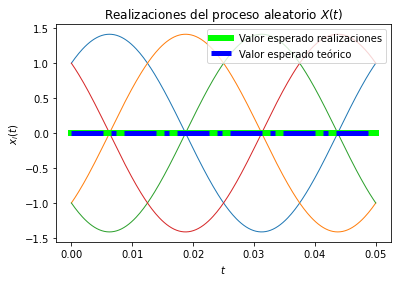

In [60]:
# Se define el tiempo para el análisis (tiempo de muestreo) 
tiempo = np.linspace(0, 0.05 ,250) #250 puntos desde 0 hasta 0.1

# Se crea un vector A donde se contienen los únicos dos valores que puede tomar este
A=[1,-1]


X_t = np.empty((4, len(tiempo)))   

plt.figure()

  #Con este for se obtienen todos los posibles valores para el tiempo en análisis
for i in A:
    s1 = i * np.cos(2*(np.pi)*fc*tiempo) +  i * np.sin(2*(np.pi)*fc*tiempo)
    s2 = -i * np.cos(2*(np.pi)*fc*tiempo) +  i * np.sin(2*(np.pi)*fc*tiempo) 
    
    
    X_t[i,:] = s1
    X_t[i+1,:] = s2
    plt.plot(tiempo,s1, lw=1) #Se obtienen las gráficas para s1 y s2
    plt.plot(tiempo, s2, lw=1)       


P = [np.mean(X_t[:,i]) for i in range(len(tiempo))] #Se obtinene la media
plt.plot(tiempo, P, lw=6,color='lime',label='Valor esperado realizaciones')


Valor_esperado_senal = np.mean(senal_Tx)*tiempo   #Se obtiene la media teórica
plt.plot(tiempo, Valor_esperado_senal, '-.', lw=5,color='b',label='Valor esperado teórico')

#Se grafica
plt.title('Realizaciones del proceso aleatorio $X(t)$')
plt.xlabel('$t$')
plt.ylabel('$x_i(t)$')
plt.legend()
plt.show()

### 4.3. - Densidad espectral de potencia

* (20%) Determine y grafique la densidad espectral de potencia para la señal modulada `senal_Tx`.

<ipython-input-59-75433e4fa3c4>:4: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  senal_f = fft(senal_Tx)


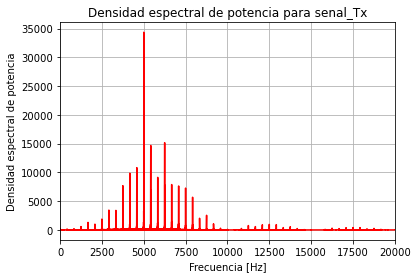

In [59]:
from scipy import fft

#Transformada de Fourier
senal_f = fft(senal_Tx)

#Muestras de la señal
Nm = len(senal_Tx)

#Número de símbolos (198 x 89 x 8 x 3)
Ns = Nm//mpp

#Tiempo del símbolo = periódo de la onda portadora
Tc = 1 / fc

#Tiempo entre muestras (periódo de muestreo)
Tm = Tc / mpp

#Tiempo de la simulación 
T = Ns * Tc

#Espacio de frecuencias
f = np.linspace(0.0, 1.0/(2.0*Tm), Nm//2)


#Gráfica
plt.plot(f, 2.0/Nm * np.power(np.abs(senal_f[0:Nm//2]), 2), color = 'red')
plt.xlim(0, 20000)
plt.title('Densidad espectral de potencia para senal_Tx') 
plt.grid()
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad espectral de potencia')
plt.show()


---

### Universidad de Costa Rica
#### Facultad de Ingeniería
##### Escuela de Ingeniería Eléctrica

---